In [1]:
import glob
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
import os
import pandas as pd
import pickle
import re

import sys
sys.path.append('/Users/zeynepenkavi/Documents/RangelLab/DescribedVsLearned_fmri/analysis/01_level1')
from level1_utils import run_level1, make_level1_design_matrix, get_events

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
data_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/bids_nifti_wface/'
behavior_path = '/Users/zeynepenkavi/Downloads/GTavares_2017_arbitration/behavioral_data/all_trials.csv'
out_path = os.path.join(data_path, "derivatives/nilearn/glm/level1/")

subnum = '01'
runnum='4'

A 'modulation' column was found in the given events data and is used.


/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/_utils/glm.py:310: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')


<AxesSubplot:label='conditions', ylabel='scan number'>

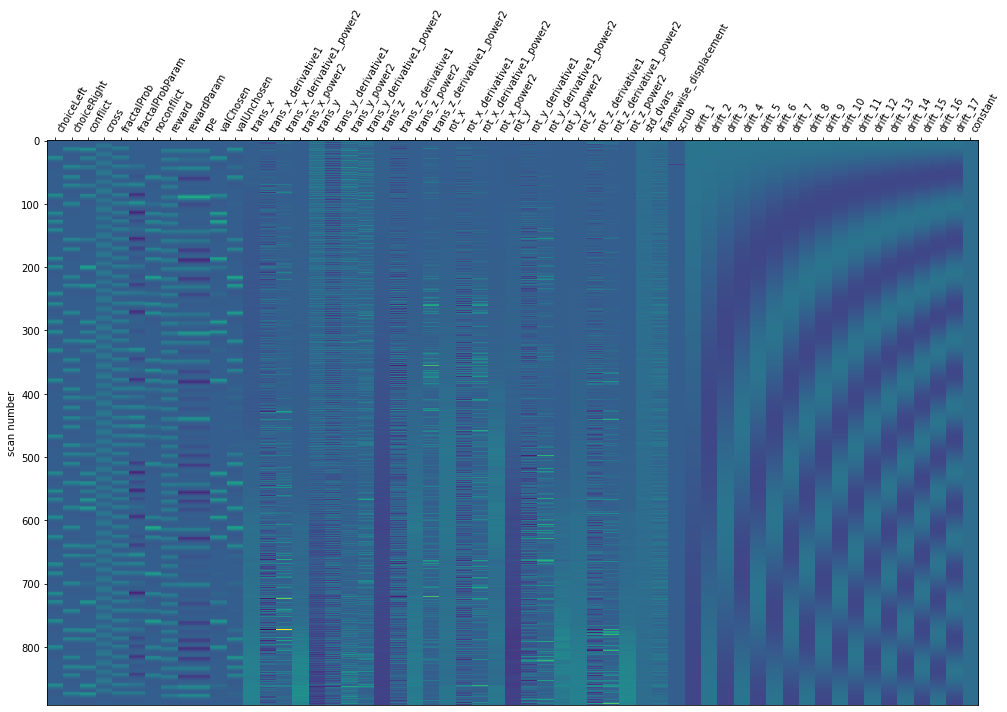

In [3]:
design_matrix_rt0= make_level1_design_matrix(subnum, runnum, data_path, behavior_path, regress_rt = 0)
plot_design_matrix(design_matrix_rt0)

In [4]:
beh_regs = design_matrix_rt0.columns
beh_regs = [i for i in beh_regs if '_' not in i]
beh_regs = [i for i in beh_regs if 'scrub' not in i]
beh_regs = [i for i in beh_regs if 'constant' not in i]
design_matrix_rt0[beh_regs].corr()

,choiceLeft,choiceRight,conflict,cross,fractalProb,fractalProbParam,noconflict,reward,rewardParam,rpe,valChosen,valUnchosen
choiceLeft,1.000000,-0.350082,0.253520,-0.417826,0.453877,-0.105682,0.329573,0.200311,-0.053633,-0.053633,0.791300,-0.275473
choiceRight,-0.350082,1.000000,0.327487,-0.488671,0.551531,0.100783,0.235018,0.271602,0.049499,0.049499,-0.285726,0.740472
conflict,0.253520,0.327487,1.000000,-0.477853,0.392011,0.020758,-0.288931,0.300506,0.278657,0.278657,0.221958,0.289613
cross,-0.417826,-0.488671,-0.477853,1.000000,-0.549370,0.004726,-0.464389,-0.711303,-0.022624,-0.022624,-0.368879,-0.424842
fractalProb,0.453877,0.551531,0.392011,-0.549370,1.000000,0.006043,0.377543,0.027088,0.000569,0.000569,0.306728,0.341923
fractalProbParam,-0.105682,0.100783,0.020758,0.004726,0.006043,1.000000,-0.142026,0.032470,0.027677,0.027677,-0.313751,-0.251044
noconflict,0.329573,0.235018,-0.288931,-0.464389,0.377543,-0.142026,1.000000,0.294054,-0.252008,-0.252008,0.297288,0.393344
reward,0.200311,0.271602,0.300506,-0.711303,0.027088,0.032470,0.294054,1.000000,0.006339,0.006339,0.237644,0.262815
rewardParam,-0.053633,0.049499,0.278657,-0.022624,0.000569,0.027677,-0.252008,0.006339,1.000000,1.000000,-0.087427,0.033939
rpe,-0.053633,0.049499,0.278657,-0.022624,0.000569,0.027677,-0.252008,0.006339,1.000000,1.000000,-0.087427,0.033939


In [ ]:
design_matrix_rt1= make_level1_design_matrix(subnum, runnum, data_path, behavior_path, regress_rt = 1)
plot_design_matrix(design_matrix_rt1)

In [ ]:
beh_regs = design_matrix_rt1.columns
beh_regs = [i for i in beh_regs if '_' not in i]
beh_regs = [i for i in beh_regs if 'scrub' not in i]
beh_regs = [i for i in beh_regs if 'constant' not in i]
design_matrix_rt1[beh_regs].corr()

Difference between the design matrices with and without rt regressors for the regressors that it matters for

In [ ]:
rt_regs = ['cross', 'valChosen', 'valUnchosen', 'conflict', 'noconflict']
plot_design_matrix(design_matrix_rt0[rt_regs] - design_matrix_rt1[rt_regs])

In [5]:
behavior = pd.read_csv(behavior_path)

# Extract the correct subnum and runnum from behavioral data
run_behavior = behavior.query('subnum == %d & session == %d'%(int(subnum), int(runnum)))

In [8]:
run_behavior['reward']

180    1.0
181    1.0
182    1.0
183    0.0
184    0.0
185    2.0
186    0.0
187    1.0
188    0.9
189    1.0
190    1.0
191    0.0
192    0.0
193    0.7
194    0.0
195    1.0
196    0.0
197    0.0
198    1.0
199    1.0
200    2.0
201    1.0
202    0.0
203    1.0
204    0.0
205    0.0
206    0.0
207    0.0
208    0.0
209    1.0
210    0.0
211    0.0
212    0.0
213    0.0
214    0.0
215    0.7
216    1.0
217    0.0
218    0.0
219    0.0
220    0.9
221    1.0
222    0.0
223    1.0
224    0.0
225    0.0
226    0.0
227    1.0
228    0.1
229    0.0
230    0.0
231    0.0
232    0.0
233    0.0
234    0.0
235    0.0
236    1.0
237    0.0
238    1.0
239    1.0
Name: reward, dtype: float64

In [ ]:
# run_level1(subnum, data_path, behavior_path, out_path, regress_rt = 1)

In [ ]:
# run_level1(subnum, data_path, behavior_path, out_path, regress_rt = 0)

In [ ]:
# contrast_id = 'valDiff'
# zmap = nib.load(os.path.join(out_path, 'sub-%s/contrasts/sub-%s_run-%s_%s.nii.gz'%(subnum, subnum, runnum, contrast_id)))
# plot_stat_map(zmap, threshold=3.0, title='sub-%s_run-%s_%s' % (subnum, runnum, contrast_id))